In [1]:
# import pandas as pd
import cudf as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tabulate import tabulate

In [2]:
# Load daily stock data

daily = pd.read_csv('../data/data.csv', index_col=False)

daily

,Unnamed: 0,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,insert_id,update_id
0,0,AAT,2016-05-02,29.71,30.31,29.51,30.220,305480.0,2595.0,30.160000,scheduled__2016-05-01T00:00:00+00:00,scheduled__2016-05-01T00:00:00+00:00
1,1,AAT,2016-05-03,30.16,30.58,30.07,30.480,207380.0,1660.0,30.340000,scheduled__2016-05-01T00:00:00+00:00,scheduled__2016-05-01T00:00:00+00:00
2,2,AAT,2016-05-04,30.39,31.15,30.39,31.010,224614.0,1983.0,30.980000,scheduled__2016-05-01T00:00:00+00:00,scheduled__2016-05-01T00:00:00+00:00
3,3,AAT,2016-05-05,30.88,31.18,30.78,30.910,110657.0,1349.0,30.920000,scheduled__2016-05-01T00:00:00+00:00,scheduled__2016-05-01T00:00:00+00:00
4,4,AAT,2016-05-06,30.77,31.11,30.65,31.110,196848.0,1443.0,30.980000,scheduled__2016-05-01T00:00:00+00:00,scheduled__2016-05-01T00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
6984274,6984274,THRY,2024-07-20,18.10,18.13,17.96,18.060,53857.0,278.0,18.544783,scheduled__2024-07-20T00:00:00+00:00,scheduled__2024-07-20T00:00:00+00:00
6984275,6984275,VIGI,2024-07-20,83.40,83.54,83.37,83.540,64808.0,359.0,81.420212,scheduled__2024-07-20T00:00:00+00:00,scheduled__2024-07-20T00:00:00+00:00
6984276,6984276,TPIC,2024-07-20,4.50,4.52,4.32,4.430,50158.0,295.0,4.242977,scheduled__2024-07-20T00:00:00+00:00,scheduled__2024-07-20T00:00:00+00:00
6984277,6984277,UVV,2024-07-20,50.90,51.00,50.73,50.815,77382.0,460.0,50.090344,scheduled__2024-07-20T00:00:00+00:00,scheduled__2024-07-20T00:00:00+00:00


In [3]:
# Transformations

daily['timestamp'] = daily['timestamp'].astype(str).str[:10]
daily['timestamp'] = pd.to_datetime(daily['timestamp'])

daily['caldt'] = daily['timestamp'].dt.strftime("%Y-%m-%d")
daily['mdt'] = daily['timestamp'].dt.strftime("%Y-%m")

daily = daily[(daily['caldt'] >= '2021-01-01') & (daily['caldt'] <= '2023-12-31')]

daily = daily[['symbol','caldt','mdt','close']].copy()

daily = daily.sort_values(by=['symbol','caldt'])

daily = daily.reset_index(drop=True)

daily['ret'] = daily.groupby('symbol')['close'].pct_change()

daily

,symbol,caldt,mdt,close,ret
0,A,2021-01-04,2021-01,115.99,<NA>
1,A,2021-01-05,2021-01,116.94,0.008190361
2,A,2021-01-06,2021-01,120.14,0.02736446
3,A,2021-01-07,2021-01,123.34,0.026635592
4,A,2021-01-08,2021-01,124.22,0.007134749
...,...,...,...,...,...
2710840,ZYME,2023-12-22,2023-12,9.83,0.05472103
2710841,ZYME,2023-12-26,2023-12,10.68,0.08646999
2710842,ZYME,2023-12-27,2023-12,10.75,0.006554307
2710843,ZYME,2023-12-28,2023-12,10.70,-0.004651163


In [4]:
# Aggregation to monthly data

monthly = daily.groupby(['symbol','mdt'])[['caldt','close']].agg({'caldt': 'last','close': 'last'})

monthly = monthly.reset_index()

monthly

,symbol,mdt,caldt,close
0,A,2021-01,2021-01-29,117.48
1,A,2021-02,2021-02-26,119.34
2,A,2021-03,2021-03-31,124.30
3,A,2021-04,2021-04-30,130.85
4,A,2021-05,2021-05-28,135.24
...,...,...,...,...
129736,ZYME,2023-08,2023-08-31,7.24
129737,ZYME,2023-09,2023-09-29,6.34
129738,ZYME,2023-10,2023-10-31,7.02
129739,ZYME,2023-11,2023-11-30,8.87


In [5]:
# Generate features

monthly['ret'] = monthly.groupby('symbol')['close'].pct_change()

monthly['logret'] = np.log(1+monthly['ret'])

monthly['mom'] = monthly.groupby('symbol')['logret'].rolling(11,11).sum().reset_index(drop=True)

monthly['momlag'] = monthly.groupby('symbol')['mom'].shift(1)

monthly

,symbol,mdt,caldt,close,ret,logret,mom,momlag
0,A,2021-01,2021-01-29,117.48,<NA>,<NA>,<NA>,<NA>
1,A,2021-02,2021-02-26,119.34,0.015832482,0.015708456,<NA>,<NA>
2,A,2021-03,2021-03-31,124.30,0.041561924,0.040721436,<NA>,<NA>
3,A,2021-04,2021-04-30,130.85,0.052695093,0.05135363,<NA>,<NA>
4,A,2021-05,2021-05-28,135.24,0.033549866,0.032999349,<NA>,<NA>
...,...,...,...,...,...,...,...,...
129736,ZYME,2023-08,2023-08-31,7.24,-0.029490617,-0.029934208,0.163169125,0.151696143
129737,ZYME,2023-09,2023-09-29,6.34,-0.124309392,-0.132742438,-0.15864709,0.163169125
129738,ZYME,2023-10,2023-10-31,7.02,0.107255521,0.10188445,-0.095051146,-0.15864709
129739,ZYME,2023-11,2023-11-30,8.87,0.263532764,0.233911578,0.12088819,-0.095051146


In [6]:
# Trading filters

monthly['prclag'] = monthly.groupby('symbol')['close'].shift(1)

monthly = monthly.query('momlag == momlag and prclag >= 5')

# Portfolio generation

monthly['score'] = monthly.groupby('mdt')['momlag'].rank(ascending=False)

port = monthly[monthly['score'] <= 100].reset_index(drop=True).copy()

port

,symbol,mdt,caldt,close,ret,logret,mom,momlag,prclag,score
0,AA,2022-01,2022-01-31,55.32,-0.048176,-0.049375,0.839256,1.199167,58.12,32.0
1,AA,2022-02,2022-02-28,73.49,0.328453,0.284015,0.843360,0.839256,55.32,39.0
2,AA,2022-03,2022-03-31,87.92,0.196353,0.179278,0.902398,0.843360,73.49,37.0
3,AA,2022-04,2022-04-29,66.21,-0.246929,-0.283596,0.539320,0.902398,87.92,45.0
4,AA,2022-05,2022-05-31,60.38,-0.088053,-0.092174,0.521035,0.539320,66.21,76.0
...,...,...,...,...,...,...,...,...,...,...
2395,ZIM,2022-02,2022-02-28,34.40,0.045911,0.044888,1.141981,1.296945,32.89,10.0
2396,ZIM,2022-03,2022-03-31,43.73,0.271221,0.239978,0.951313,1.141981,34.40,20.0
2397,ZIM,2022-04,2022-04-29,33.46,-0.234850,-0.267684,0.469645,0.951313,43.73,38.0
2398,ZIM,2022-06,2022-06-30,29.59,-0.258396,-0.298940,0.516701,0.677728,39.90,54.0


In [7]:
# Merge portfolio with daily data to create backtest

port = port[['symbol','mdt','score']]

test = pd.merge(left=daily,right=port,on=['symbol','mdt'], how='inner')

test

,symbol,caldt,mdt,close,ret,score
0,AAON,2023-04-10,2023-04,62.47,0.016268,66.0
1,AAON,2023-04-11,2023-04,62.75,0.004482,66.0
2,AAON,2023-04-12,2023-04,63.95,0.019124,66.0
3,AAON,2023-04-13,2023-04,64.37,0.006568,66.0
4,AAON,2023-04-14,2023-04,63.27,-0.017089,66.0
...,...,...,...,...,...,...
50095,ZIM,2022-04-04,2022-04,40.40,-0.058933,38.0
50096,ZIM,2022-04-05,2022-04,37.20,-0.079208,38.0
50097,ZIM,2022-04-06,2022-04,35.62,-0.042473,38.0
50098,ZIM,2022-04-07,2022-04,35.95,0.009264,38.0


In [8]:
# Backtest Transformations

test = test.groupby('caldt')['ret'].mean().to_frame().reset_index()

test = test.sort_values(by='caldt').reset_index(drop=True)

test['cumret'] = (1+test['ret']).cumprod() - 1

test

,caldt,ret,cumret
0,2022-01-03,0.001660,0.001660
1,2022-01-04,-0.003562,-0.001908
2,2022-01-05,-0.042961,-0.044787
3,2022-01-06,0.011776,-0.033538
4,2022-01-07,-0.022098,-0.054895
...,...,...,...
496,2023-12-22,0.008412,0.183142
497,2023-12-26,0.018225,0.204704
498,2023-12-27,0.011680,0.218775
499,2023-12-28,-0.010224,0.206314


In [9]:
# Load benchmark daily data

bmk = pd.read_csv('../data/bmk.csv',index_col=False)

bmk

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,200.490005,201.029999,198.589996,201.020004,173.483505,222353500
1,2016-01-05,201.399994,201.899994,200.050003,201.360001,173.776993,110845800
2,2016-01-06,198.339996,200.059998,197.600006,198.820007,171.584854,152112600
3,2016-01-07,195.330002,197.440002,193.589996,194.050003,167.468338,213436100
4,2016-01-08,195.190002,195.850006,191.580002,191.919998,165.630112,209817200
...,...,...,...,...,...,...,...
2007,2023-12-22,473.859985,475.380005,471.700012,473.649994,470.664490,67126600
2008,2023-12-26,474.070007,476.579987,473.989990,475.649994,472.651886,55387000
2009,2023-12-27,475.440002,476.660004,474.890015,476.510010,473.506500,68000300
2010,2023-12-28,476.880005,477.549988,476.260010,476.690002,473.685333,77158100


In [10]:
# Transformations

bmk['Date'] = pd.to_datetime(bmk['Date'])

bmk['caldt'] = bmk['Date'].dt.strftime("%Y-%m-%d")
bmk['mdt'] = bmk['Date'].dt.strftime("%Y-%m")

bmk = bmk.rename(columns={'Adj Close': 'close'})

bmk = bmk[['caldt','mdt','close']]

bmk = bmk[bmk['caldt'] >= test['caldt'].min()]

bmk['ret'] = bmk['close'].pct_change()
bmk['cumret'] = (1+bmk['ret']).cumprod() - 1

bmk = bmk.drop(columns=['close', 'mdt'])

bmk = bmk.reset_index(drop = True)

bmk

,caldt,ret,cumret
0,2022-01-03,<NA>,<NA>
1,2022-01-04,-0.000334871,-0.000334871
2,2022-01-05,-0.019202182,-0.019530622
3,2022-01-06,-0.000939391,-0.020451667
4,2022-01-07,-0.003953459,-0.024324271
...,...,...,...
496,2023-12-22,0.002009706,0.022900622
497,2023-12-26,0.004222533,0.027219853
498,2023-12-27,0.001808126,0.029077196
499,2023-12-28,0.000377678,0.029465856


<Axes: xlabel='caldt', ylabel='cumret'>

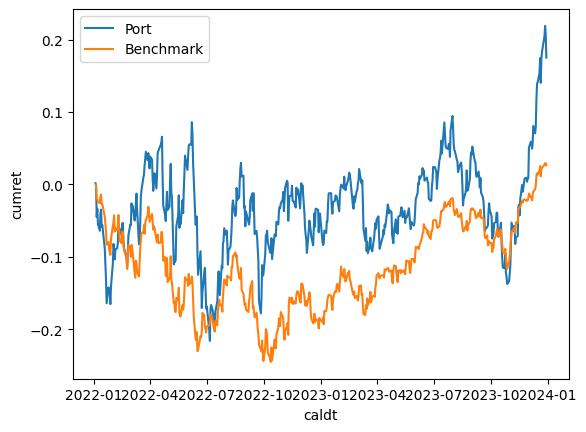

In [11]:
# Chart

test['caldt'] = pd.to_datetime(test['caldt'])
bmk['caldt'] = pd.to_datetime(bmk['caldt'])

test = test.to_pandas()
bmk = bmk.to_pandas()

sns.lineplot(data=test,x='caldt',y='cumret', label='Port')
sns.lineplot(data=bmk,x='caldt',y='cumret', label='Benchmark')

In [12]:
# Metrics

port_cumret = test['cumret'].iloc[-1] 
bmk_cumret = bmk['cumret'].iloc[-1]

port_ret = port_cumret / test['cumret'].count() * 250
bmk_ret = bmk_cumret / bmk['cumret'].count() * 250

port_vol = test['ret'].std()
bmk_vol = bmk['ret'].std()

port_er = test['ret'].mean()
bmk_er = bmk['ret'].mean()

correlation = test['ret'].corr(bmk['ret'])
covariance = test['ret'].cov(bmk['ret'])

beta = covariance / (bmk_vol**2)

In [13]:
# Create a table with the results
table = [
    ["Metric", "Portfolio", "Benchmark"],
    ["Total Return", f"% {round(port_cumret * 100, 2)}", f"% {round(bmk_cumret * 100, 2)}" ],
    ["Annual Return", f"% {round(port_ret * 100, 2)}", f"% {round(bmk_ret * 100, 2)}"],
    ["Expected Return", f"% {round(port_er * 100,2)}", f"% {round(bmk_er * 100,2)}"],
    ["Volatility", f"% {round(port_vol * 100,2)}", f"% {round(bmk_vol * 100,2)}"],
    ["Sharpe", f"{round((port_er / port_vol * 100),2)}", f"{round((bmk_er / bmk_vol * 100),2)}"],
    ["Correlation", round(correlation,2)],
    ["Beta", round(beta,2)]
]

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------------+-------------+-------------+
| Metric          | Portfolio   | Benchmark   |
+=================+=============+=============+
| Total Return    | % 17.5      | % 2.65      |
+-----------------+-------------+-------------+
| Annual Return   | % 8.73      | % 1.32      |
+-----------------+-------------+-------------+
| Expected Return | % 0.05      | % 0.01      |
+-----------------+-------------+-------------+
| Volatility      | % 1.96      | % 1.23      |
+-----------------+-------------+-------------+
| Sharpe          | 2.63        | 1.04        |
+-----------------+-------------+-------------+
| Correlation     | 0.68        |             |
+-----------------+-------------+-------------+
| Beta            | 1.08        |             |
+-----------------+-------------+-------------+
